# Classfication Network Architecture

I am unable to get flowers classification network to get a validation accuracy > 48%. Try out different techniques including the same architecture I used to train CIFAR10 images

@date: 06-Aug-2020 | @author: katnoria

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [6]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [7]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

In [8]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [9]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [18]:
IMG_SIZE = 32
BATCH_SIZE = 64

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [19]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [20]:
example = train_ds.take(1)

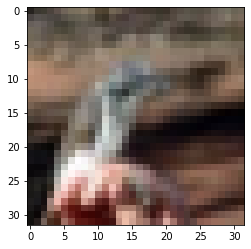

In [21]:
for images, labels in example:
    plt.imshow(images[0])

### Evaluation Pipeline

In [22]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [25]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

In [26]:
def get_pretrained_model(base_model):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)    
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [27]:
resnet_model = get_pretrained_model(base_model)
resnet_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [28]:
lr = 1e-4
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [29]:
# Let's see the eval accuracy before we train the model
resnet_model.evaluate(test_ds)

156/156 [==============================] - 2s 10ms/step - loss: 6.4664 - accuracy: 0.1017


[6.466416835784912, 0.10166265815496445]

In [30]:
# We are going to train for 50 epochs
history = resnet_model.fit(train_ds, epochs=50, validation_data=test_ds, verbose=2)

Epoch 1/50
781/781 - 9s - loss: 3.2065 - accuracy: 0.3572 - val_loss: 1.6666 - val_accuracy: 0.5428
Epoch 2/50
781/781 - 9s - loss: 2.0541 - accuracy: 0.4962 - val_loss: 1.3957 - val_accuracy: 0.5913
Epoch 3/50
781/781 - 9s - loss: 1.7320 - accuracy: 0.5372 - val_loss: 1.2516 - val_accuracy: 0.6181
Epoch 4/50
781/781 - 8s - loss: 1.5132 - accuracy: 0.5653 - val_loss: 1.1659 - val_accuracy: 0.6345
Epoch 5/50
781/781 - 9s - loss: 1.3555 - accuracy: 0.5876 - val_loss: 1.1043 - val_accuracy: 0.6428
Epoch 6/50
781/781 - 9s - loss: 1.2571 - accuracy: 0.6012 - val_loss: 1.0678 - val_accuracy: 0.6532
Epoch 7/50
781/781 - 9s - loss: 1.1744 - accuracy: 0.6175 - val_loss: 1.0381 - val_accuracy: 0.6550
Epoch 8/50
781/781 - 9s - loss: 1.1100 - accuracy: 0.6300 - val_loss: 1.0118 - val_accuracy: 0.6623
Epoch 9/50
781/781 - 9s - loss: 1.0733 - accuracy: 0.6389 - val_loss: 0.9940 - val_accuracy: 0.6660
Epoch 10/50
781/781 - 9s - loss: 1.0343 - accuracy: 0.6478 - val_loss: 0.9869 - val_accuracy: 0.6667

### Plot the plots

In [37]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

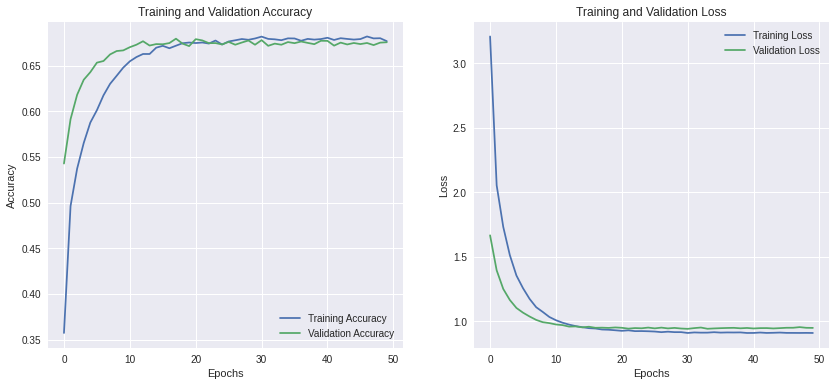

In [38]:
plot_history(history)

# Data Augmentation

In [39]:
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [40]:
def get_pretrained_model(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)    
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [41]:
resnet_model_v2 = get_pretrained_model(base_model, transforms)
resnet_model_v2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [42]:
lr = 1e-4
resnet_model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [43]:
# Let's see the eval accuracy before we train the model
resnet_model_v2.evaluate(test_ds)

  1/156 [..............................] - ETA: 0s - loss: 6.6830 - accuracy: 0.0625WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0036s vs `on_test_batch_end` time: 0.0056s). Check your callbacks.


156/156 [==============================] - 1s 9ms/step - loss: 6.3933 - accuracy: 0.1025


[6.393298625946045, 0.10246394574642181]

In [44]:
# We are going to train for 50 epochs
history = resnet_model_v2.fit(train_ds, epochs=50, validation_data=test_ds, verbose=2)

Epoch 1/50
781/781 - 9s - loss: 3.1533 - accuracy: 0.3558 - val_loss: 1.6378 - val_accuracy: 0.5380
Epoch 2/50
781/781 - 9s - loss: 2.0302 - accuracy: 0.4958 - val_loss: 1.3916 - val_accuracy: 0.5843
Epoch 3/50
781/781 - 9s - loss: 1.7090 - accuracy: 0.5390 - val_loss: 1.2529 - val_accuracy: 0.6128
Epoch 4/50
781/781 - 9s - loss: 1.5116 - accuracy: 0.5657 - val_loss: 1.1700 - val_accuracy: 0.6278
Epoch 5/50
781/781 - 8s - loss: 1.3587 - accuracy: 0.5855 - val_loss: 1.1075 - val_accuracy: 0.6359
Epoch 6/50
781/781 - 9s - loss: 1.2467 - accuracy: 0.6045 - val_loss: 1.0717 - val_accuracy: 0.6452
Epoch 7/50
781/781 - 9s - loss: 1.1678 - accuracy: 0.6186 - val_loss: 1.0426 - val_accuracy: 0.6501
Epoch 8/50
781/781 - 9s - loss: 1.1195 - accuracy: 0.6307 - val_loss: 1.0149 - val_accuracy: 0.6564
Epoch 9/50
781/781 - 9s - loss: 1.0686 - accuracy: 0.6429 - val_loss: 0.9958 - val_accuracy: 0.6625
Epoch 10/50
781/781 - 9s - loss: 1.0339 - accuracy: 0.6481 - val_loss: 0.9852 - val_accuracy: 0.6635

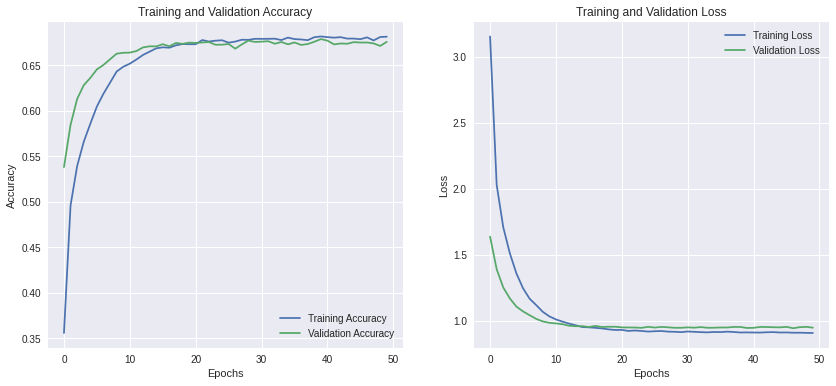

In [45]:
plot_history(history)